# Sparse reduced-rank regression for exploratory visualization<br>of Patch-seq recordings

### *Dmitry Kobak, Yves Bernaerts, Marissa A. Weis, and Philipp Berens*

https://www.biorxiv.org/content/10.1101/302208

<img src="figure-rrr.png"  alt="Sparse reduced-rank regression for patch-seq data">

The loss function for reduced-rank regression with elastic net penalty:

$$\mathcal L = \lVert \mathbf Y - \mathbf X \mathbf W \mathbf V^\top\rVert^2 + \lambda \Big(\alpha \sum_{i=1}^p\lVert \mathbf W_{i\cdot}\rVert_2 + (1-\alpha) \lVert \mathbf W \rVert^2\Big) \;\;\;\text{s.t.}\; \mathbf V^\top\mathbf V = \mathbf I.$$

In [1]:
%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import pickle
from scipy import io
import matplotlib

import glmnet_python
from glmnet import glmnet

# Two .py files in this directory
import sparseRRR
import spls_scca

# This file is from https://github.com/berenslab/rna-seq-tsne
import sys; sys.path.append('../rna-seq-tsne/')
import rnaseqTools

def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size'] = 3
    matplotlib.rcParams['ytick.major.size'] = 3
    matplotlib.rcParams['xtick.minor.size'] = 2
    matplotlib.rcParams['ytick.minor.size'] = 2
    matplotlib.rcParams['font.size']       = 7
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 7
    matplotlib.rcParams['legend.fontsize'] = 7
    matplotlib.rcParams['xtick.labelsize'] = 7
    matplotlib.rcParams['ytick.labelsize'] = 7

## Scala et al. dataset

In [2]:
# Load the data

data = pd.read_csv("../../BICCN patch-seq data/L4/rnaseq/counts.csv", sep='\t')
counts = data.values[:,1:].transpose().astype(float)
genes = data.values[:,0]
cells = np.array(data.columns[1:])

print('Number of cells: {}\nNumber of genes: {}'.format(counts.shape[0], counts.shape[1]))

meta = pd.read_excel('../../BICCN patch-seq data/L4/Layer 4 cells.xlsx', index_col=0)
d = [d[6:10]+d[:2]+d[3:5] for d in meta.values[1:,1] if d is not np.nan]
s = [s[7:].strip() if 'sample ' in s else s[6:].strip() for s in meta.values[1:,2] if s is not np.nan]
names = [d[i]+'_sample_'+s[i] for i in range(len(d))]
regions = [m for m in meta.values[1:,3] if m=='V1' or m=='S1']
layers = [m for m in meta.values[1:,4] if ~np.isnan(m)]
names2regions = dict(zip(names,regions))
names2layers = dict(zip(names,layers))

regions = np.array([names2regions['_'.join(c.split('_')[:3])] for c in cells])
layers  = np.array([names2layers['_'.join(c.split('_')[:3])] for c in cells])

ephysData = pd.read_csv('../layer4/ephys/data/patch-seq-ephys-features.csv')
ephysNames = np.array(ephysData.columns[1:-2])
ephysCells = np.array([s.split('sample')[0]+'_sample_'+s.split('sample')[1] for s in ephysData.values[:,0]])
keep = ephysData['Good quality']
ai0 = ephysData['AI']==0
ephysData = ephysData.values[:, 1:-2].astype('float')
ephysData[~keep,:] = np.nan
ephysData[keep, ephysNames=='Latency (ms)'] = np.log(ephysData[keep, ephysNames=='Latency (ms)'])
ephysData[keep & ~ai0, ephysNames=='AI'] = np.log(ephysData[keep & ~ai0, ephysNames=='AI']/100)
ephysData[ai0, ephysNames=='AI'] = np.nan
names2ephys = dict(zip(ephysCells, ephysData))
ephys = np.array([names2ephys['_'.join(c.split('_')[:3])] if '_'.join(c.split('_')[:3]) in names2ephys
          else np.ones(ephysNames.size)*np.nan for c in cells]).astype(float)

l4 = {'counts': counts, 'cells': cells, 'genes': genes, 
      'regions': regions, 'layers': layers, 'ephys': ephys,
      'ephysNames': ephysNames}

print('')
print(ephysNames)
print(ephysNames.size)

Number of cells: 118
Number of genes: 26514

['ADP (mV)' 'AHP (mV)' 'AI' 'AP amplitude (mV)' 'AP threshold (mV)'
 'AP width (ms)' 'Max number of spikes' 'Input R (MOhm)' 'Vm (mV)'
 'Latency (ms)' 'Rheobase (pA)' 'Sag ratio' 'Tau (ms)']
13


Chosen offset: 7.08


<IPython.core.display.Javascript object>


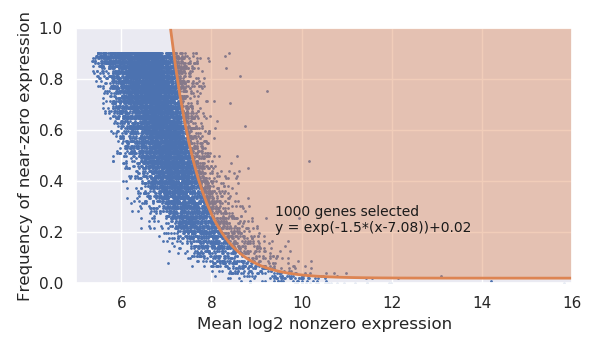

Shape of X: (102, 1000) 
Shape of Y: (102, 13)


In [254]:
# cells to exclude based on RNA (either low quality or maps to PV/excitatory
exclude = ['20180605_sample_12_L4_S109', '20180626_sample_11_L4_S129',
           '20180703_sample_6_L4_S157', '20180919_sample_21_L4_S136',
           '20180605_sample_17_L4_S114', '20180626_sample_7_L4_S125',
           '20180627_sample_1_L4_S137', '20180703_sample_4_L4_S154']

selection = ~np.isin(l4['cells'], exclude) & ~np.isnan(np.sum(l4['ephys'],axis=1))

genesForRRR = rnaseqTools.geneSelection(l4['counts'][selection,:], n=1000, threshold=32)

X = l4['counts'][selection,:] / np.sum(l4['counts'][selection,:], axis=1, keepdims=True) * 1e+6
X = np.log2(X + 1)
X = X[:, genesForRRR]
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)

Y = l4['ephys'][selection,:]
Y = Y - np.mean(Y, axis=0)
Y = Y / np.std(Y, axis=0)

print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

l4['selection'] = selection
l4['genesForRRR'] = genesForRRR
l4['X'] = X
l4['Y'] = Y

1.......... Time: 0.0h  0m 47s


<IPython.core.display.Javascript object>


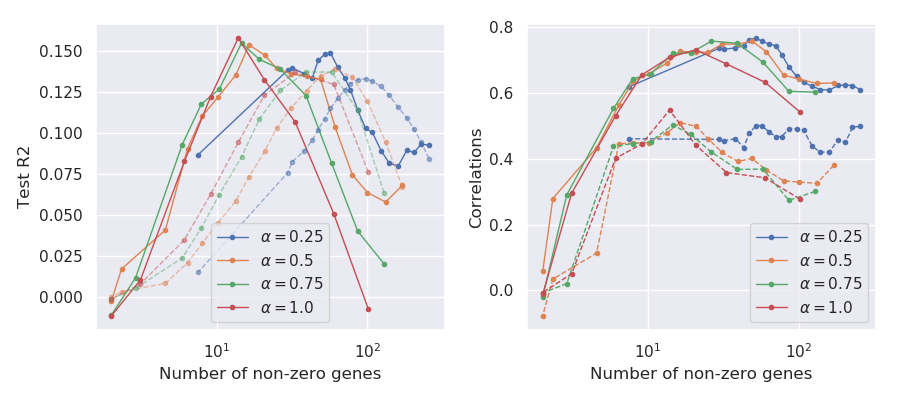

In [4]:
# sRRR cross-validatation

lambdas = np.concatenate([np.arange(.1,3,.1), np.arange(3,11)])
alphas = np.array([.25, .5, .75, 1])

cvResults = sparseRRR.elastic_rrr_cv(X, Y, rank=2, reps=1, folds=10, alphas=alphas, lambdas=lambdas)

sparseRRR.plot_cv_results(*cvResults, alphas)

Genes selected: 20


<IPython.core.display.Javascript object>


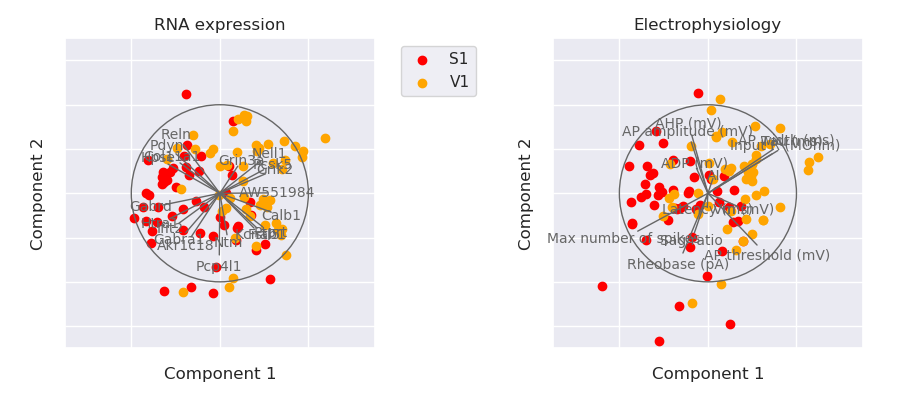

In [191]:
# sRRR bibiplot

w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=1, alpha=.5)
print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))

sparseRRR.bibiplot(X, Y, w, v, 
                   titles=['RNA expression', 'Electrophysiology'],
                   cellTypes=l4['regions'][selection], 
                   cellTypeColors={'V1':'orange','S1':'red'}, 
                   cellTypeLabels = {'V1':'V1','S1':'S1'}, 
                   YdimsNames=l4['ephysNames'], XdimsNames=l4['genes'][genesForRRR],
                   xylim = 3.5)

In [6]:
# Gene selection stability

bootCounts = sparseRRR.elastic_rrr_bootstrap(X, Y, rank=2, lambdau=1, alpha=.5)

for ii in np.argsort(bootCounts)[::-1][:20]:
    print('{:10} {:.2f}'.format(l4['genes'][genesForRRR][ii], bootCounts[ii]))

.................................................................................................... 
Htra1      0.83
Akr1c18    0.78
Gabrd      0.75
Reln       0.72
Pdyn       0.70
Ifit2      0.69
Calb1      0.68
Fstl5      0.67
Gabra1     0.56
AW551984   0.52
Ptprt      0.45
Grin3a     0.43
Ifit1      0.39
Camkv      0.37
Col11a1    0.37
Pgrmc1     0.37
Hpse       0.37
Pcsk5      0.34
Grik2      0.33
Ntm        0.29


<IPython.core.display.Javascript object>


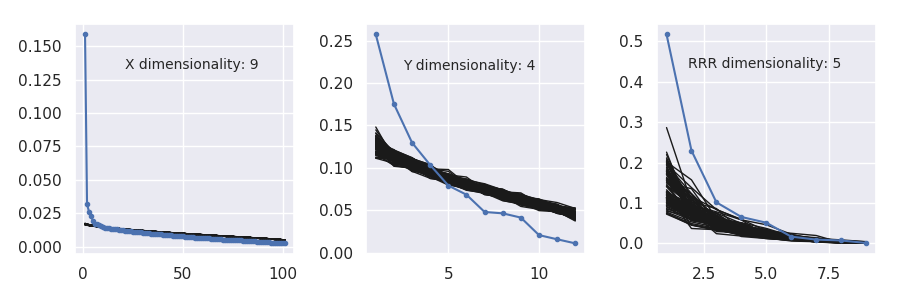

In [255]:
sparseRRR.dimensionality(X, Y)

## Cadwell et al. dataset

In [14]:
# Load the data

data = pd.read_excel('cadwellData/Data_CortexInterneurons.xlsx', sheet_name="readcounts")
cells  = np.array([int(c[5:-1]) for c in data.values[2,2:-5]])
genes  = np.array([c[1:-1] for c in data.values[4:,1]])
counts = data.values[4:,2:-5].T.astype('float')

print('Number of cells: {}\nNumber of genes: {}'.format(counts.shape[0], counts.shape[1]))

varGenes = pd.read_excel('https://media.nature.com/original/nature-assets/nbt/journal/v34/n2/extref/nbt.3445-S3.xlsx')
varGenes = varGenes.values[3:,-1]
varGenes = np.array([g[1:-1] for g in varGenes])
lgenes = list(genes)
counts = counts[:, [lgenes.index(g) for g in varGenes]]

from scipy import io
mat = io.loadmat('cadwellData/IntPhysiologyFinal.mat')
types = np.array([mat['cell'][0][n][3][0][0] for n in range(len(mat['cell'][0]))])
idxs  = np.array([mat['cell'][0][n][0][0][0] for n in range(len(mat['cell'][0]))])

cols = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
ephysNames = np.array(['V_rest', 'R_input', 'AP tau', 'AP thresh', 'AP width', 'AP amp', 'AHP', 'ADP', 
                   'Adapt', 'ifDelayed', 'ifBurst'])
ephys = np.zeros((idxs.size, len(cols)))
for j,c in enumerate(cols):
    ephys[:,j] = [mat['cell'][0][i][c][0][0] for i in range(len(mat['cell'][0]))]

# Int_44 and Int_45 were removed from the Cadwell et al. due to possible contamination
keep = (idxs != 44) & (idxs != 45) & ~np.isnan(np.sum(ephys,axis=1))
types = types[keep]
idxs  =  idxs[keep]
ephys = ephys[keep]
counts = counts[[np.where(cells==i)[0][0] for i in idxs], :]

cadwell = {'counts': counts, 'ephys': ephys, 'cellTypes': types, 
           'ephysNames': ephysNames, 'genes': varGenes}

print('Number of cells: {}\nNumber of genes: {}'.format(counts.shape[0], counts.shape[1]))
print('')
print(ephysNames)
print(ephysNames.size)

Number of cells: 44
Number of genes: 15074

['V_rest' 'R_input' 'AP tau' 'AP thresh' 'AP width' 'AP amp' 'AHP' 'ADP'
 'Adapt' 'ifDelayed' 'ifBurst']
11


In [17]:
# Plotting parameters for Cadwell data

colors = np.zeros((5,3))
colors[0,:] = [217,95,2]
colors[-1,:] = [27,158,119]
for i in range(1,4):
    colors[i,:] = colors[0,:] * (5-i)/4 + colors[-1,:] * i/4
colors = colors/256

cellTypeColors = dict(zip(range(1,6), colors))
cellTypeLabels = dict(zip(range(1,6), ['NGC', None, None, None,'SBC']))

cadwell['colors'] = cellTypeColors
cadwell['labels'] = cellTypeLabels

In [256]:
# Library size normalization and log transform
X = cadwell['counts'] / np.sum(cadwell['counts'], axis=1, keepdims=True) * 1e+6
X = np.log2(X + 1)
X = X[:,:3000]

Y = cadwell['ephys']

# Standardize X
mu = np.mean(X, axis=0)
X = X - mu
sigma = np.std(X, axis=0)
X = X / sigma

# Standardize Y
mu = np.mean(Y, axis=0)
Y = Y - mu
sigma = np.std(Y, axis=0)
Y = Y / sigma

print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

cadwell['X'] = X
cadwell['Y'] = Y

Shape of X: (44, 3000) 
Shape of Y: (44, 11)


1........... Time: 0.0h  1m 25s


<IPython.core.display.Javascript object>


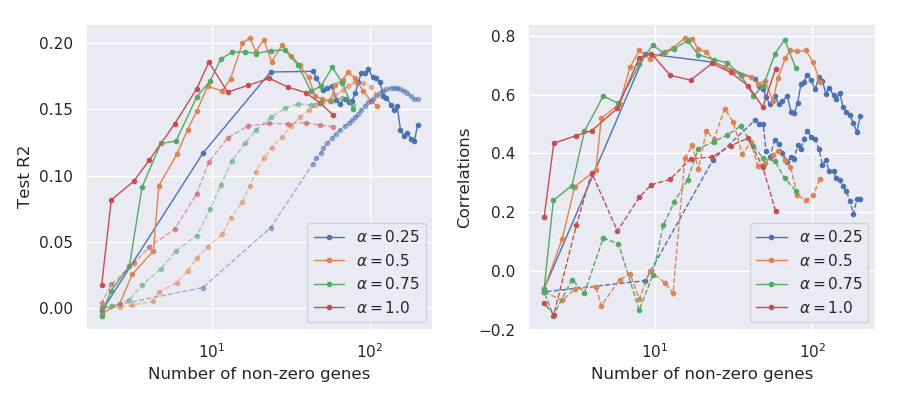

In [38]:
# sRRR cross-validatation

lambdas = np.concatenate([np.arange(.1,3,.1), np.arange(3,11)])
alphas = np.array([.25, .5, .75, 1])

cvResults = sparseRRR.elastic_rrr_cv(X, Y, rank=2, reps=1, folds=11, alphas=alphas, lambdas=lambdas)

sparseRRR.plot_cv_results(*cvResults, alphas)

Number of genes selected: 22


<IPython.core.display.Javascript object>


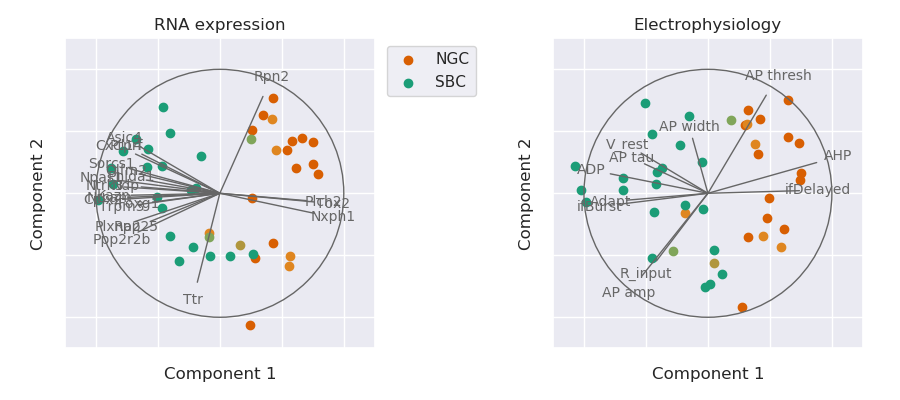

In [37]:
# sRRR bibiplot

w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, alpha=.5, lambdau=1.5)
print('Number of genes selected: {}'.format(np.sum(w[:,0]!=0)))

sparseRRR.bibiplot(X, Y, w, v, titles=['RNA expression', 'Electrophysiology'],
         cellTypes=cadwell['cellTypes'], cellTypeColors=cadwell['colors'], cellTypeLabels = cadwell['labels'],
         YdimsNames=cadwell['ephysNames'], XdimsNames=cadwell['genes'],
         xylim = 2.5)

In [36]:
# Gene selection stability

bootCounts = sparseRRR.elastic_rrr_bootstrap(X, Y, rank=2, lambdau=1.5, alpha=.5)

for ii in np.argsort(bootCounts)[::-1][:20]:
    print('{:10} {:.2f}'.format(cadwell['genes'][ii], bootCounts[ii]))

.................................................................................................... 
Kazn       0.71
Cplx2      0.49
Plch2      0.46
Ntrk3      0.46
Nrcam      0.45
Plxna2     0.42
Ppp2r2b    0.39
Tox2       0.38
Ndp        0.36
Rpn2       0.36
Sorcs1     0.35
Asic4      0.33
Rpp25      0.28
Slamf9     0.27
Trpm3      0.26
Olfm2      0.26
Efcab7     0.25
Col4a1     0.24
Foxg1      0.23
Npas1      0.23


<IPython.core.display.Javascript object>


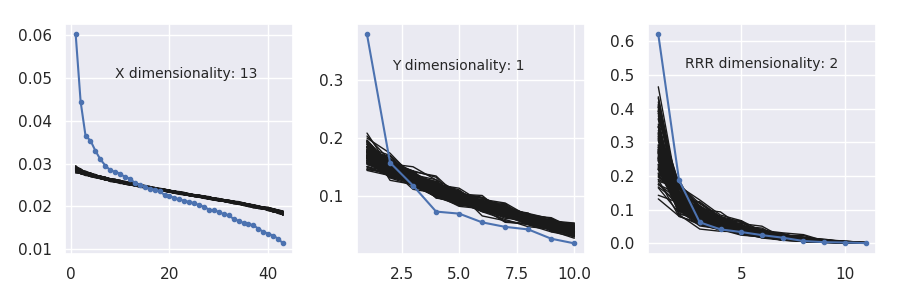

In [257]:
sparseRRR.dimensionality(X, Y)

## FIGURE: PCA of X and Y in both datasets

<IPython.core.display.Javascript object>


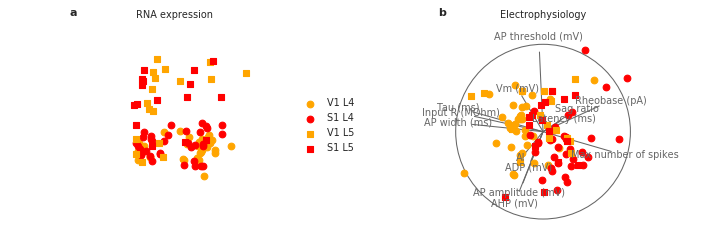

In [251]:
sns_styleset()
plt.figure(figsize=(7.2, 2.5))

#################################

# X = cadwell['X']
# Y = cadwell['Y']

# from sklearn.decomposition import PCA
# Zx = PCA(n_components=2, svd_solver='full').fit_transform(X)  
# Zy = PCA(n_components=2, svd_solver='full').fit_transform(Y)  
# Zx = Zx / np.std(Zx, axis=0)
# Zy = Zy / np.std(Zy, axis=0)
    
# plt.subplot(221, aspect='equal')
# for ct in np.unique(cadwell['cellTypes']):
#     plt.scatter(Zx[cadwell['cellTypes']==ct,0], Zx[cadwell['cellTypes']==ct,1], 
#                 color=cadwell['colors'][ct], zorder=2, label=cadwell['labels'][ct])
# plt.legend(frameon=False, bbox_to_anchor=(1.4, .7))
# plt.ylim([-3.6, 3.6])
# plt.xlim([-3.6, 3.6])
# plt.xticks([])
# plt.yticks([])
# plt.title('RNA expression')

# plt.subplot(222, aspect='equal')
# for ct in np.unique(cadwell['cellTypes']):
#     plt.scatter(Zy[cadwell['cellTypes']==ct,0], Zy[cadwell['cellTypes']==ct,1], 
#                 color=cadwell['colors'][ct], zorder=2)
# plt.ylim([-3.6, 3.6])
# plt.xlim([-3.6, 3.6])
# plt.xticks([])
# plt.yticks([])
# plt.title('Electrophysiology')

# L = np.corrcoef(np.concatenate((Zy[:,:2], Y), axis=1), rowvar=False)[2:,:2]
# for i in range(Y.shape[1]):
#     plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, 
#              color=[.4, .4, .4], zorder=1)
#     plt.text(scaleFactor*L[i,0]*1.2, scaleFactor*L[i,1]*1.2, cadwell['ephysNames'][i], 
#              ha='center', va='center', color=[.4, .4, .4], fontsize=7)
# circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.75)
# plt.gca().add_patch(circ)

#################################

X = l4['X']
Y = l4['Y']

Zx = PCA(n_components=2, svd_solver='full').fit_transform(X)  
Zy = PCA(n_components=2, svd_solver='full').fit_transform(Y)  
Zx = Zx / np.std(Zx, axis=0)
Zy = Zy / np.std(Zy, axis=0)
    
plt.subplot(121, aspect='equal')
# plt.scatter(Zx[l4['regions'][selection]=='V1',0], Zx[l4['regions'][selection]=='V1',1], 
#             color='orange', zorder=2, label='V1')
# plt.scatter(Zx[l4['regions'][selection]=='S1',0], Zx[l4['regions'][selection]=='S1',1], 
#             color='red', zorder=2, label='S1')
plt.scatter(Zx[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==4),0],
            Zx[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==4),1],
            color='orange', zorder=2, label='V1 L4')
plt.scatter(Zx[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==4),0],
            Zx[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==4),1],
            color='red', zorder=2, label='S1 L4')
plt.scatter(Zx[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==5),0],
            Zx[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==5),1],
            color='orange', zorder=2, label='V1 L5', marker='s')
plt.scatter(Zx[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==5),0],
            Zx[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==5),1],
            color='red', zorder=2, label='S1 L5', marker='s')

plt.legend(frameon=False, bbox_to_anchor=(1.4, .7))
plt.ylim([-3.6, 3.6])
plt.xlim([-3.6, 3.6])
plt.xticks([])
plt.yticks([])
plt.title('RNA expression')

plt.subplot(122, aspect='equal')
# plt.scatter(Zy[l4['regions'][selection]=='V1',0], Zy[l4['regions'][selection]=='V1',1], 
#             color='orange', zorder=2)
# plt.scatter(Zy[l4['regions'][selection]=='S1',0], Zy[l4['regions'][selection]=='S1',1], 
#             color='red', zorder=2)
plt.scatter(Zy[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==4),0],
            Zy[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==4),1],
            color='orange', zorder=2)
plt.scatter(Zy[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==4),0],
            Zy[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==4),1],
            color='red', zorder=2)
plt.scatter(Zy[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==5),0],
            Zy[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==5),1],
            color='orange', zorder=2, marker='s')
plt.scatter(Zy[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==5),0],
            Zy[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==5),1],
            color='red', zorder=2, marker='s')
plt.ylim([-3.6, 3.6])
plt.xlim([-3.6, 3.6])
plt.xticks([])
plt.yticks([])
plt.title('Electrophysiology')

L = np.corrcoef(np.concatenate((Zy[:,:2], Y), axis=1), rowvar=False)[2:,:2]
for i in range(Y.shape[1]):
    plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, color=[.4, .4, .4],
             zorder=1)
    plt.text(scaleFactor*L[i,0]*1.2, scaleFactor*L[i,1]*1.2, l4['ephysNames'][i], 
             ha='center', va='center', color=[.4, .4, .4], fontsize=7)
circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.75)
plt.gca().add_patch(circ)

#################################

sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.text(0, 1.05,  'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=8, fontweight='bold')
plt.text(0, 1.05,  'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=8, fontweight='bold')
# plt.text(0, 1.05,  'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=8, fontweight='bold')
# plt.text(0, 1.05,  'd', transform = plt.gcf().get_axes()[3].transAxes, fontsize=8, fontweight='bold')

# plt.gcf().text(.03,.24, 'Scala et al.', rotation=90, fontsize=8, va='center', 
#                bbox=dict(facecolor='#aaaaaa', boxstyle='round'))
# plt.gcf().text(.03,.74, 'Cadwell et al.', rotation=90, fontsize=8, va='center',
#                bbox=dict(facecolor='#aaaaaa', boxstyle='round'))

plt.savefig('revision-figures/pca.png', dpi=200)
plt.savefig('revision-figures/pca.pdf')

In [258]:
# plt.figure(figsize=(5,4))
# plt.scatter(Zx[:,0], Zx[:,1], c=np.sum(l4['counts'][l4['selection'],:], axis=1))
# plt.colorbar()
# plt.title('PCA in the gene space for L4 data, colored by number of reads')
# plt.savefig('revision-figures/l4-pca-x.png')

## FIGURE: Cross-validation in both datasets

In [259]:
%%time

X = l4['X']
Y = l4['Y']

lambdas = np.concatenate([np.arange(.1,3,.1), np.arange(2,11)])
alphas = [.25, .5, .75, 1]
ranks = np.arange(1, Y.shape[1]+1)

cvresults = {}
for r in ranks:
    cvresults[r] = sparseRRR.elastic_rrr_cv(X, Y, lambdas=lambdas, alphas=alphas, reps=10, rank=r, folds=10)
    
# pickle.dump([cvresults, lambdas, alphas, ranks], open('cvresults-scala.pickle', 'wb'))

1.......... 2.......... 3.......... 4.......... 5.......... 6.......... 7.......... 8.......... 9.......... 10.......... Time: 0.0h  4m 55s
1......

KeyboardInterrupt: 

In [260]:
%%time

X = cadwell['X']
Y = cadwell['Y']

lambdas = np.concatenate([np.arange(.1,3,.1), np.arange(2,11)])
alphas = [.25, .5, .75, 1]
ranks = np.arange(1, Y.shape[1]+1)

cvresults = {}
for r in ranks:
    cvresults[r] = sparseRRR.elastic_rrr_cv(X, Y, lambdas=lambdas, alphas=alphas, reps=10, rank=r, folds=11)
    
# pickle.dump([cvresults, lambdas, alphas, ranks], open('cvresults-cadwell.pickle', 'wb'))

1........... 2........... 3........... 4........... 5........... 6........... 7........... 8........... 9........... 10........... Time: 0.0h  4m 27s
1.

KeyboardInterrupt: 

In [41]:
cvresultsScala,   lambdas, alphas, ranks = pickle.load(open('cvresults-scala.pickle', 'rb'))
cvresultsCadwell, lambdas, alphas, ranks = pickle.load(open('cvresults-cadwell.pickle', 'rb'))

<IPython.core.display.Javascript object>


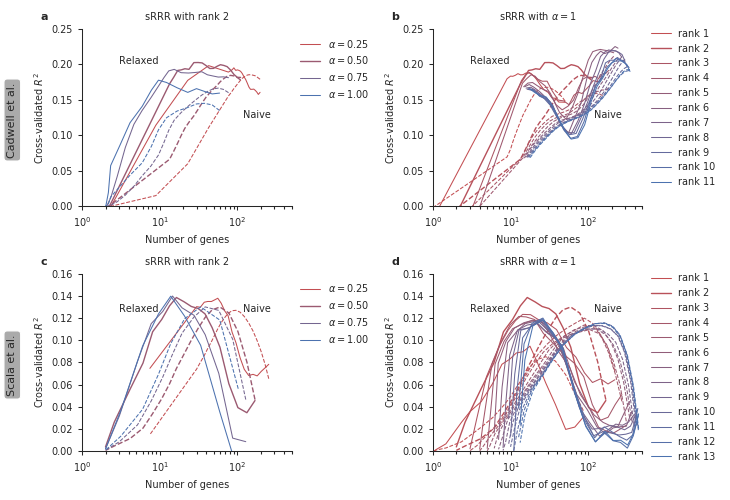

In [116]:
import warnings

sns_styleset()
plt.figure(figsize=(7.3, 5))

ylims = [.25, .16]
relypos = [.2, .125]

for datasetnum, cvresults in enumerate([cvresultsCadwell, cvresultsScala]):

    plt.subplot(2,2,datasetnum*2+1)
    colA = np.array([76, 114, 176]) / 256
    colB = np.array([196, 78, 82])  / 256
    for alphaid in range(4):
        # suppressing "mean of empty slice" warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            n = np.nanmean(cvresults[2][2], axis=(0,1))
            c = np.nanmean(cvresults[2][0], axis=(0,1))
            cr = np.nanmean(cvresults[2][1], axis=(0,1))
        
        if alphaid==1:
            lw = 1
        else:
            lw = .75
        col = (colA * alphaid/3 + colB * (3-alphaid)/3)
        plt.plot(n[:,alphaid], cr[:,alphaid], linewidth=lw, color=col, 
                 label=r'$\alpha={:.2f}$'.format(alphas[alphaid]))
        plt.plot(n[:,alphaid], c[:,alphaid], '--', linewidth=lw, color=col)

    plt.legend(frameon=False, bbox_to_anchor=(1, 1))
    plt.xscale('log')
    plt.xlabel('Number of genes')
    plt.ylabel(r'Cross-validated $R^2$')
    plt.title('sRRR with rank 2')
    plt.ylim([0, ylims[datasetnum]])
    plt.xlim([1, 500])
    plt.text(3,relypos[datasetnum], 'Relaxed', fontsize=7)
    plt.text(120,.125, 'Naive', fontsize=7)

    plt.subplot(2,2,datasetnum*2+2)
    colA = np.array([76, 114, 176]) / 256
    colB = np.array([196, 78, 82])  / 256
    maxRank = len(cvresults)
    for rank in range(1,maxRank+1):
        # suppressing "mean of empty slice" warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            n = np.nanmean(cvresults[rank][2], axis=(0,1))
            c = np.nanmean(cvresults[rank][0], axis=(0,1))
            cr = np.nanmean(cvresults[rank][1], axis=(0,1))
    
        if rank==2:
            lw = 1
        else:
            lw = .75
        col = (colA * (rank-1)/(maxRank-1) + colB * (maxRank-rank)/(maxRank-1))
        plt.plot(n[:,1], cr[:,1], color=col, linewidth=lw,
                 label='rank {}'.format(rank))
        plt.plot(n[:,1], c[:,1], '--', color=col, linewidth=lw)

    plt.legend(frameon=False, bbox_to_anchor=(1, 1.05))
    plt.xscale('log')
    plt.xlabel('Number of genes')
    plt.ylabel(r'Cross-validated $R^2$')
    plt.title(r'sRRR with $\alpha={}$'.format(alphas[alphaid]))
    plt.ylim([0, ylims[datasetnum]])
    plt.xlim([1, 500])
    plt.text(3,relypos[datasetnum], 'Relaxed', fontsize=7)
    plt.text(120,.125, 'Naive', fontsize=7)

sns.despine()
plt.tight_layout(rect=(.03,0,1,1))

plt.text(-.2, 1.05,  'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=8, fontweight='bold')
plt.text(-.2, 1.05,  'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=8, fontweight='bold')
plt.text(-.2, 1.05,  'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=8, fontweight='bold')
plt.text(-.2, 1.05,  'd', transform = plt.gcf().get_axes()[3].transAxes, fontsize=8, fontweight='bold')

plt.gcf().text(.01,.27, 'Scala et al.', rotation=90, fontsize=8, va='center', 
               bbox=dict(facecolor='#aaaaaa', boxstyle='round'))
plt.gcf().text(.01,.76, 'Cadwell et al.', rotation=90, fontsize=8, va='center',
               bbox=dict(facecolor='#aaaaaa', boxstyle='round'))

plt.savefig('revision-figures/cv.png', dpi=200)
plt.savefig('revision-figures/cv.pdf')

In [70]:
# plt.figure(figsize=(6,4))
# plt.plot(lambdas, plt.nanmean(cvresultsCadwell[9][2], axis=(0,1)), '.-')
# plt.yscale('log')

## FIGURE: bibiplots in both datasets

<IPython.core.display.Javascript object>


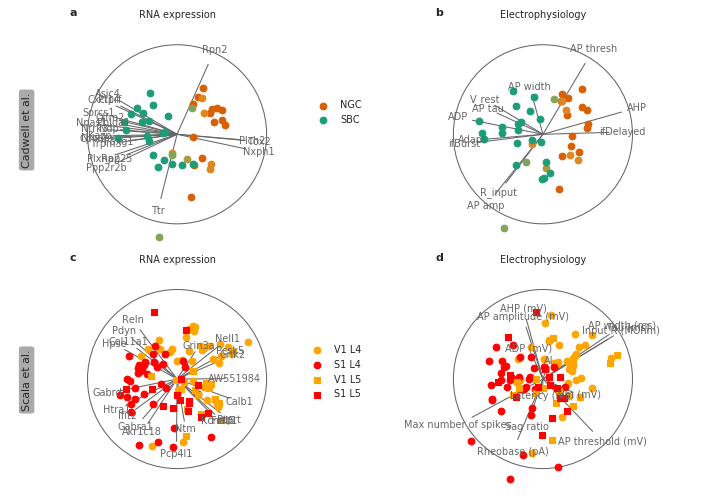

In [237]:
sns_styleset()
plt.figure(figsize=(7.2, 5))

#################################

X = cadwell['X']
Y = cadwell['Y']
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, alpha=.5, lambdau=1.5)

Zx = X @ w[:,:2]
Zy = Y @ v[:,:2]
Zx = Zx / np.std(Zx, axis=0)
Zy = Zy / np.std(Zy, axis=0)
    
plt.subplot(221, aspect='equal')
for ct in np.unique(cadwell['cellTypes']):
    plt.scatter(Zx[cadwell['cellTypes']==ct,0], Zx[cadwell['cellTypes']==ct,1], 
                color=cadwell['colors'][ct], zorder=2, label=cadwell['labels'][ct])
plt.legend(frameon=False, bbox_to_anchor=(1.4, .7))
plt.ylim([-3.6, 3.6])
plt.xlim([-3.6, 3.6])
plt.xticks([])
plt.yticks([])
plt.title('RNA expression')

scaleFactor = 3
L = np.corrcoef(np.concatenate((Zx[:,:2], X), axis=1), rowvar=False)[2:,:2]
for i in np.where(w[:,0]!=0)[0]:
    plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, 
             color=[.4, .4, .4], zorder=1)
    plt.text(scaleFactor*L[i,0]*1.2, scaleFactor*L[i,1]*1.2, cadwell['genes'][i], 
             ha='center', va='center', color=[.4, .4, .4], fontsize=7)
circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.75)
plt.gca().add_patch(circ)

plt.subplot(222, aspect='equal')
for ct in np.unique(cadwell['cellTypes']):
    plt.scatter(Zy[cadwell['cellTypes']==ct,0], Zy[cadwell['cellTypes']==ct,1], 
                color=cadwell['colors'][ct], zorder=2)
plt.ylim([-3.6, 3.6])
plt.xlim([-3.6, 3.6])
plt.xticks([])
plt.yticks([])
plt.title('Electrophysiology')

L = np.corrcoef(np.concatenate((Zy[:,:2], Y), axis=1), rowvar=False)[2:,:2]
for i in range(Y.shape[1]):
    plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, 
             color=[.4, .4, .4], zorder=1)
    plt.text(scaleFactor*L[i,0]*1.2, scaleFactor*L[i,1]*1.2, cadwell['ephysNames'][i], 
             ha='center', va='center', color=[.4, .4, .4], fontsize=7)
circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.75)
plt.gca().add_patch(circ)

#################################

X = l4['X']
Y = l4['Y']
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=2, lambdau=1, alpha=.5)

Zx = X @ w[:,:2]
Zy = Y @ v[:,:2]
Zx = Zx / np.std(Zx, axis=0)
Zy = Zy / np.std(Zy, axis=0)
    
plt.subplot(223, aspect='equal')
# plt.scatter(Zx[l4['regions'][selection]=='V1',0], Zx[l4['regions'][selection]=='V1',1], 
#             color='orange', zorder=2, label='V1')
# plt.scatter(Zx[l4['regions'][selection]=='S1',0], Zx[l4['regions'][selection]=='S1',1], 
#             color='red', zorder=2, label='S1')
plt.scatter(Zx[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==4),0],
            Zx[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==4),1],
            color='orange', zorder=2, label='V1 L4')
plt.scatter(Zx[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==4),0],
            Zx[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==4),1],
            color='red', zorder=2, label='S1 L4')
plt.scatter(Zx[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==5),0],
            Zx[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==5),1],
            color='orange', zorder=2, label='V1 L5', marker='s')
plt.scatter(Zx[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==5),0],
            Zx[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==5),1],
            color='red', zorder=2, label='S1 L5', marker='s')
plt.legend(frameon=False, bbox_to_anchor=(1.4, .7))
plt.ylim([-3.6, 3.6])
plt.xlim([-3.6, 3.6])
plt.xticks([])
plt.yticks([])
plt.title('RNA expression')

scaleFactor = 3
L = np.corrcoef(np.concatenate((Zx[:,:2], X), axis=1), rowvar=False)[2:,:2]
for i in np.where(w[:,0]!=0)[0]:
    plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, color=[.4, .4, .4],
             zorder=1)
    plt.text(scaleFactor*L[i,0]*1.2, scaleFactor*L[i,1]*1.2, l4['genes'][l4['genesForRRR']][i], 
             ha='center', va='center', color=[.4, .4, .4], fontsize=7)
circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.75)
plt.gca().add_patch(circ)

plt.subplot(224, aspect='equal')
# plt.scatter(Zy[l4['regions'][selection]=='V1',0], Zy[l4['regions'][selection]=='V1',1], 
#             color='orange', zorder=2)
# plt.scatter(Zy[l4['regions'][selection]=='S1',0], Zy[l4['regions'][selection]=='S1',1], 
#             color='red', zorder=2)
plt.scatter(Zy[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==4),0],
            Zy[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==4),1],
            color='orange', zorder=2)
plt.scatter(Zy[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==4),0],
            Zy[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==4),1],
            color='red', zorder=2)
plt.scatter(Zy[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==5),0],
            Zy[(l4['regions'][selection]=='V1')&(l4['layers'][selection]==5),1],
            color='orange', zorder=2, marker='s')
plt.scatter(Zy[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==5),0],
            Zy[(l4['regions'][selection]=='S1')&(l4['layers'][selection]==5),1],
            color='red', zorder=2, marker='s')
plt.ylim([-3.6, 3.6])
plt.xlim([-3.6, 3.6])
plt.xticks([])
plt.yticks([])
plt.title('Electrophysiology')

L = np.corrcoef(np.concatenate((Zy[:,:2], Y), axis=1), rowvar=False)[2:,:2]
for i in range(Y.shape[1]):
    plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=.75, color=[.4, .4, .4],
             zorder=1)
    plt.text(scaleFactor*L[i,0]*1.2, scaleFactor*L[i,1]*1.2, l4['ephysNames'][i], 
             ha='center', va='center', color=[.4, .4, .4], fontsize=7)
circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.75)
plt.gca().add_patch(circ)

#################################

sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.text(0, 1.05,  'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=8, fontweight='bold')
plt.text(0, 1.05,  'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=8, fontweight='bold')
plt.text(0, 1.05,  'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=8, fontweight='bold')
plt.text(0, 1.05,  'd', transform = plt.gcf().get_axes()[3].transAxes, fontsize=8, fontweight='bold')

plt.gcf().text(.03,.24, 'Scala et al.', rotation=90, fontsize=8, va='center', 
               bbox=dict(facecolor='#aaaaaa', boxstyle='round'))
plt.gcf().text(.03,.74, 'Cadwell et al.', rotation=90, fontsize=8, va='center',
               bbox=dict(facecolor='#aaaaaa', boxstyle='round'))

plt.savefig('revision-figures/bibiplots.png', dpi=200)
plt.savefig('revision-figures/bibiplots.pdf')

## FIGURE: correlations and comparison to Witten/Suo

In [ ]:
cvresultsScala,   lambdas, alphas, ranks = pickle.load(open('cvresults-scala.pickle', 'rb'))
cvresultsCadwell, lambdas, alphas, ranks = pickle.load(open('cvresults-cadwell.pickle', 'rb'))

In [162]:
X = l4['X']
Y = l4['Y']

lx_scan = np.arange(20, 75, 5)
%time corr_witten_scala, nonz_witten_scala = spls_scca.witten_cv(X, Y, lx_scan, ncomps=2)

lx_scan = np.concatenate((np.arange(.1,1,.1), np.arange(1, 5, .5)))
%time corr_suo_scala, nonz_suo_scala = spls_scca.suo_cv(X, Y, lx_scan)

.......... done
CPU times: user 25.7 s, sys: 100 ms, total: 25.8 s
Wall time: 6.47 s
..

/home/localadmin/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/localadmin/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


........ done
CPU times: user 1h 31min 33s, sys: 40 s, total: 1h 32min 13s
Wall time: 23min 4s


In [167]:
X = cadwell['X']
Y = cadwell['Y']

lx_scan = np.arange(30, 75, 5)
%time corr_witten_cadwell, nonz_witten_cadwell = spls_scca.witten_cv(X, Y, lx_scan, ncomps=2, folds=11)

lx_scan = np.concatenate((np.arange(.1,1,.1), np.arange(1, 5, .5)))
%time corr_suo_cadwell, nonz_suo_cadwell = spls_scca.suo_cv(X, Y, lx_scan, folds=11)

.

/home/localadmin/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/localadmin/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


......... done
CPU times: user 13.1 s, sys: 80 ms, total: 13.2 s
Wall time: 3.3 s
.......... done
CPU times: user 1h 40min 26s, sys: 34 s, total: 1h 41min
Wall time: 25min 16s


In [168]:
corr_witten = [corr_witten_cadwell, corr_witten_scala]
nonz_witten = [nonz_witten_cadwell, nonz_witten_scala]
corr_suo = [corr_suo_cadwell, corr_suo_scala]
nonz_suo = [nonz_suo_cadwell, nonz_suo_scala]

pickle.dump([corr_witten, nonz_witten, corr_suo, nonz_suo], open('cvresults-wittensuo.pickle', 'wb'))

In [165]:
corr_witten, nonz_witten, corr_suo, nonz_suo = pickle.load(open('cvresults-wittensuo.pickle', 'rb'))

<IPython.core.display.Javascript object>


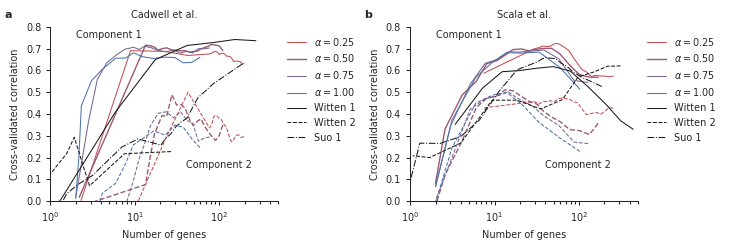

In [177]:
sns_styleset()
plt.figure(figsize=(7.3, 2.5))

titles = ['Cadwell et al.', 'Scala et al.']

for datasetnum, cvresults in enumerate([cvresultsCadwell, cvresultsScala]):

    plt.subplot(1,2,datasetnum+1)
    colA = np.array([76, 114, 176]) / 256
    colB = np.array([196, 78, 82])  / 256
    for alphaid in range(4):
        # suppressing "mean of empty slice" warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            n = np.nanmean(cvresults[2][2], axis=(0,1))
            c = np.nanmean(cvresults[2][4], axis=(0,1))
                    
        if alphaid==1:
            lw = 1
        else:
            lw = .75
        col = (colA * alphaid/3 + colB * (3-alphaid)/3)
        plt.plot(n[:,alphaid], c[:,alphaid,0], linewidth=lw, color=col, 
                 label=r'$\alpha={:.2f}$'.format(alphas[alphaid]))
        plt.plot(n[:,alphaid], c[:,alphaid,1], '--', linewidth=lw, color=col)
        
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
            
        plt.plot(np.nanmean(nonz_witten[datasetnum][:,:,:,0], axis=(0,1)), 
             np.nanmean(corr_witten[datasetnum][:,:,:,0], axis=(0,1)), 
             'k', linewidth=.75, label='Witten 1')
        plt.plot(np.nanmean(nonz_witten[datasetnum][:,:,:,1], axis=(0,1)), 
             np.nanmean(corr_witten[datasetnum][:,:,:,1], axis=(0,1)), 
             'k--', linewidth=.75, label='Witten 2')
        plt.plot(np.nanmean(nonz_suo[datasetnum][:,:,:], axis=(0,1)), 
             np.nanmean(corr_suo[datasetnum][:,:,:], axis=(0,1)), 
             'k-.', linewidth=.75, label='Suo 1')

    plt.legend(frameon=False, bbox_to_anchor=(1, 1))
    plt.xscale('log')
    plt.xlabel('Number of genes')
    plt.ylabel('Cross-validated correlation')
    plt.title(titles[datasetnum])
    plt.ylim([0, .8])
    plt.xlim([1, 500])
    
    plt.text(2, .75, 'Component 1', fontsize=7)
    plt.text(40,.15, 'Component 2', fontsize=7)
    
sns.despine()
plt.tight_layout()

plt.text(-.2, 1.05,  'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=8, fontweight='bold')
plt.text(-.2, 1.05,  'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=8, fontweight='bold')

plt.savefig('revision-figures/corr.png', dpi=200)
plt.savefig('revision-figures/corr.pdf')

In [186]:
X = l4['X']
Y = l4['Y']

w,v = spls_scca.witten(X, Y, lx=58)
print(np.sum(w != 0), 'selected genes')

bootCounts = spls_scca.witten_bootstrap(X, Y, lx=58)

for ii in np.argsort(bootCounts)[::-1][:20]:
    print('{:10} {:.2f}'.format(l4['genes'][genesForRRR][ii], bootCounts[ii]))
    
print('')
X = cadwell['X']
Y = cadwell['Y']

w,v = spls_scca.witten(X, Y, lx=53)
print(np.sum(w != 0), 'selected genes')

bootCounts = spls_scca.witten_bootstrap(X, Y, lx=53)

for ii in np.argsort(bootCounts)[::-1][:20]:
    print('{:10} {:.2f}'.format(cadwell['genes'][ii], bootCounts[ii]))

21 selected genes
.................................................................................................... done
Htra1      0.77
Ifit2      0.73
Gabrd      0.71
Akr1c18    0.67
Ifit1      0.63
Gabra1     0.63
Camkv      0.56
Nell1      0.55
Grik2      0.55
AW551984   0.54
Crtac1     0.53
Npnt       0.53
Scn3b      0.52
Calb1      0.52
Rerg       0.51
Pcsk5      0.51
Gsn        0.49
Col11a1    0.48
Pgrmc1     0.47
Syt6       0.46

21 selected genes
.................................................................................................... done
Kazn       0.80
Tox2       0.73
Npas1      0.68
Ntrk3      0.67
Nrcam      0.67
Plch2      0.62
Cplx2      0.61
Tsc22d1    0.59
Nxph1      0.59
Sorcs1     0.57
Arid5a     0.55
Rgs12      0.54
Plxna2     0.53
Npas3      0.52
Olfm2      0.51
Mpped1     0.51
Ppp2r2b    0.51
Cxcl14     0.48
Egln3      0.47
Alcam      0.46
